# Task 4.2: Explanation Analysis


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.offline as py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
np.random.seed(42)



In [2]:
# Gun incidents data
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64        

In [3]:
df_incidents_dt = df_incidents_cleaned.copy()
df_incidents_dt['isKilled'] = df_incidents_dt['ratio_killed'] > 0

In [4]:
df_incidents_dt['danger_index'] = df_incidents_dt['state'].apply(lambda x: 2 if x == 'California' else 1 if x == 'Texas' else -1 if x == 'Illinois' else -2 if x == 'New York' else 0)

In [5]:
def danger_metric(num_incidents, ratio_killed):
    # You can adjust these weights based on your priorities
    weight_num_incidents = 0.7
    weight_ratio_killed = 0.3

    # Normalize the ratio_injured based on the provided ratio_killed
    ratio_injured = 1 - ratio_killed

    # Calculate the danger metric as a weighted average
    danger_metric_value = (weight_num_incidents * num_incidents +
                           weight_ratio_killed * ratio_killed) / (weight_num_incidents + weight_ratio_killed)

    return danger_metric_value

#do danger metric for dataset
# calculate num incidents per state with a count
df_incidents_dt['incident_per_state'] = df_incidents_dt.groupby('state')['state'].transform('count')
df_incidents_dt['danger_metric'] = danger_metric(df_incidents_dt['incident_per_state'], df_incidents_dt['ratio_killed'])

# make danger metric trogh 0 to 1
df_incidents_dt['danger_metric'] = df_incidents_dt['danger_metric'] / df_incidents_dt['danger_metric'].max()



In [6]:
coumns_not_to_drop_dt  = [
                        'isKilled', 
                        'n_arrested', 
                        #'n_females',
                        'avg_age_participants',
                        'participant_age_group1', 
                        'density_incident_state', 
                        #'state', 
                        #'n_injured',
                        'danger_index',
                        #'male_indicator',
                        #'ratio_killed',
                        'danger_metric'
                        ]


# broke all if you add n_killed since is higly correlated : 0.94

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   participant_age_group1  131618 non-null  category
 1   avg_age_participants    131618 non-null  int64   
 2   n_arrested              131618 non-null  int64   
 3   density_incident_state  131618 non-null  float64 
 4   isKilled                131618 non-null  bool    
 5   danger_index            131618 non-null  int64   
 6   danger_metric           131618 non-null  float64 
dtypes: bool(1), category(1), float64(2), int64(3)
memory usage: 6.3 MB


In [7]:

killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=5000, random_state=42)

not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=5000, random_state=42)


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])

# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset



target = balanced_df['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt.info()

train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 83369 to 118896
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   avg_age_participants               10000 non-null  int64  
 1   n_arrested                         10000 non-null  int64  
 2   density_incident_state             10000 non-null  float64
 3   danger_index                       10000 non-null  int64  
 4   danger_metric                      10000 non-null  float64
 5   participant_age_group1_Adult 18+   10000 non-null  bool   
 6   participant_age_group1_Child 0-11  10000 non-null  bool   
 7   participant_age_group1_Teen 12-17  10000 non-null  bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 498.0 KB


In [8]:
#Preserve the columns of test and train set
train_set_columns = train_set.columns
test_set_columns = test_set.columns

### 1.1 Lime on Decision Tree

In [9]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=60, min_samples_leaf=30)
dt = dt.fit(train_set, train_label)

In [10]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [11]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.7014285714285714
Accuracy test set  0.7113333333333334
Precision train set  0.7037803800002379
Recall train set  0.7014285714285714
F1 score train set  0.7005646331750972
Support train set  (array([0.72567222, 0.68188854]), array([0.64771429, 0.75514286]), array([0.68448068, 0.71664859]), array([3500, 3500]))


In [12]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [13]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1500
           1       0.68      0.79      0.73      1500

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.72      0.71      0.71      3000



In [14]:
import lime
import lime.lime_tabular
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Choose a sample from the test set for interpretation
sample_index = 0  # Replace with the index of the sample you want to interpret


# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not Killed', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[0], dt.predict_proba, num_features=len(train_set_columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/home/luca/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarnin

In [15]:
# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[105], dt.predict_proba, num_features=len(train_set_columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/home/luca/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarnin

## LIME on K-NN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the model
knn.fit(train_set, train_label)

# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not KIlled', 'Killed'], discretize_continuous=True)




In [17]:
# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[0], knn.predict_proba, num_features=len(train_set.columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/home/luca/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarnin

## LIME on Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier


# Create and train two Random Forest models with different criteria
clf_entropy = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators=100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators=100)

clf_gini.fit(train_set, train_label)
clf_entropy.fit(train_set, train_label)

# Create LIME explainers for both models
explainer_entropy = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, random_state=42)
explainer_gini = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, random_state=42)


In [19]:
# Explain Lime predictions for the first test set instance
explanation_entropy = explainer_entropy.explain_instance(test_set.iloc[2345], clf_entropy.predict_proba, num_features=len(train_set.columns), top_labels=1)
explanation_gini = explainer_gini.explain_instance(test_set.iloc[100], clf_gini.predict_proba, num_features=len(train_set.columns), top_labels=1)
explanation_entropy.show_in_notebook(show_table=True, show_all=True)
explanation_gini.show_in_notebook(show_table=True, show_all=True)

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/home/luca/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarnin

## Shap on Decision Tree

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


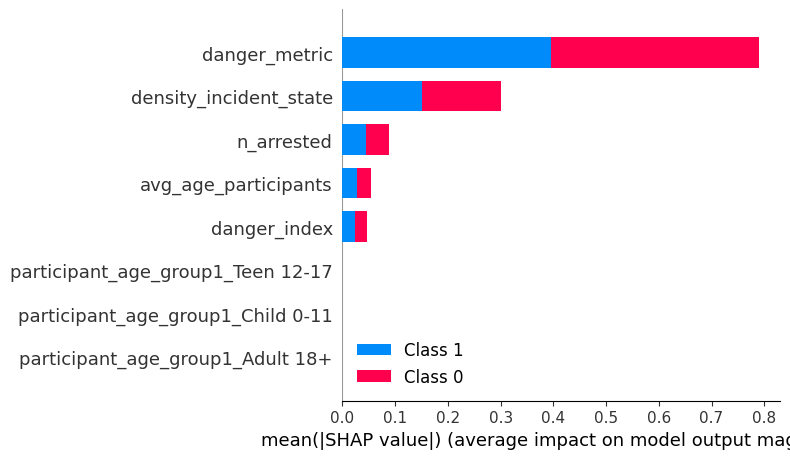

In [20]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# Create and train DecisionTree model
dtc = DecisionTreeClassifier(max_depth=50, min_samples_split=4)
dtc.fit(train_set, train_label)

# Create a SHAP explainer
explainer = shap.TreeExplainer(dtc)

# Calculate SHAP values
shap_values = explainer.shap_values(test_set)

# Create a SHAP plot for all features
shap.summary_plot(shap_values, test_set, show=True)


## SHAP on Random Forest

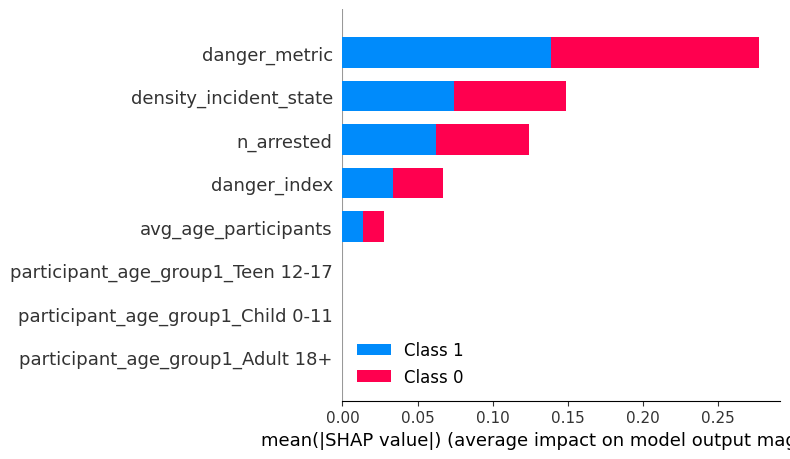

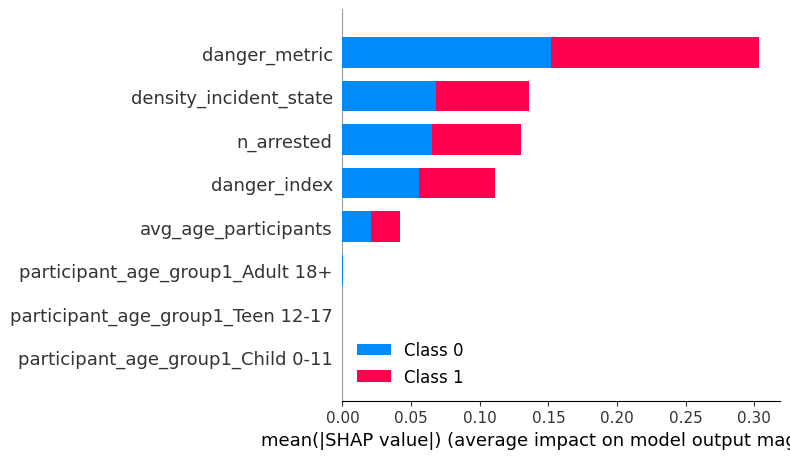

In [21]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Create and train two Random Forest models with different criteria
clf_entropy = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators=100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators=100)

clf_gini.fit(train_set, train_label)
clf_entropy.fit(train_set, train_label)

# Create SHAP explainers for both models
explainer_entropy = shap.TreeExplainer(clf_entropy)
explainer_gini = shap.TreeExplainer(clf_gini)

# Calculate SHAP values for the test set for both models
shap_values_entropy = explainer_entropy.shap_values(test_set)
shap_values_gini = explainer_gini.shap_values(test_set)

# Create SHAP summary plots for both models
shap.summary_plot(shap_values_entropy, test_set, show=True)
shap.summary_plot(shap_values_gini, test_set, show=True)


In [22]:
shap_values_entropy

[array([[-0.00802639,  0.10458491, -0.02426217, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.02554677, -0.05937535, -0.02773015, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00808039,  0.10030154, -0.02455327, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.02313469, -0.07213353, -0.02808131, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.02709349, -0.06233805, -0.02751681, ...,  0.        ,
          0.        ,  0.        ],
        [-0.01840849, -0.07501336, -0.02852163, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.00802639, -0.10458491,  0.02426217, ...,  0.        ,
          0.        ,  0.        ],
        [-0.02554677,  0.05937535,  0.02773015, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00808039, -0.10030154,  0.02455327, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.02313469,  0.07213353,  0.02808131, ...,  

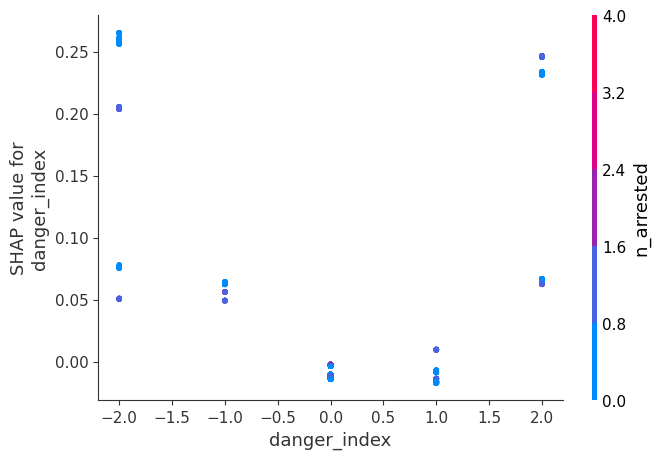

In [23]:
# Create a SHAP dependence plot for the 'n_killed' feature
shap.dependence_plot(ind='danger_index', shap_values=shap_values_entropy[0], features=test_set, show=True)
#shap.dependence_plot(ind='n_killed', shap_values_gini[0], features=test_set, show=True)



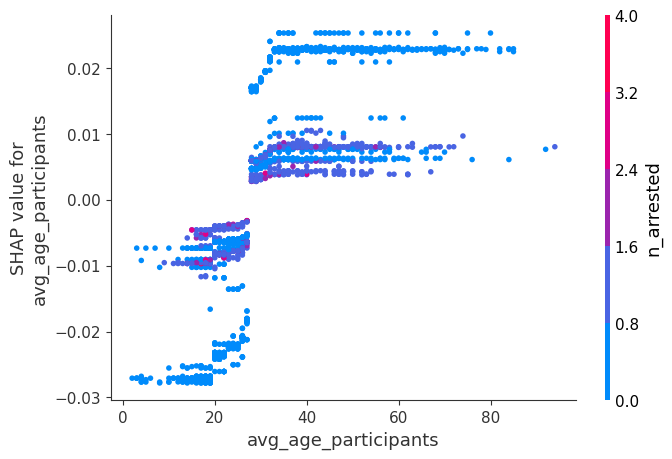

In [24]:
shap.dependence_plot(ind='avg_age_participants', shap_values=shap_values_entropy[-1], features=test_set, show=True)


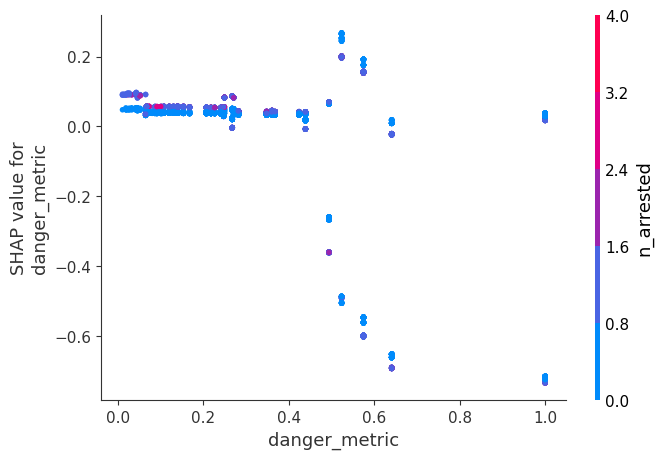

In [25]:
shap.dependence_plot(ind='danger_metric', shap_values=shap_values_entropy[0], features=test_set, show=True)


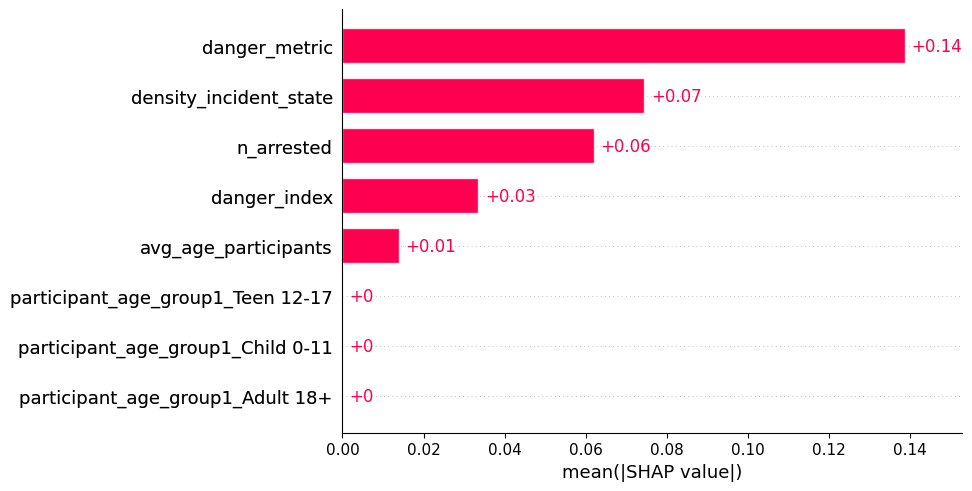

In [26]:
shap_value_bar_general = explainer_entropy(test_set)
shap.plots.bar(shap_value_bar_general[:,:,0], max_display=10, show=True)


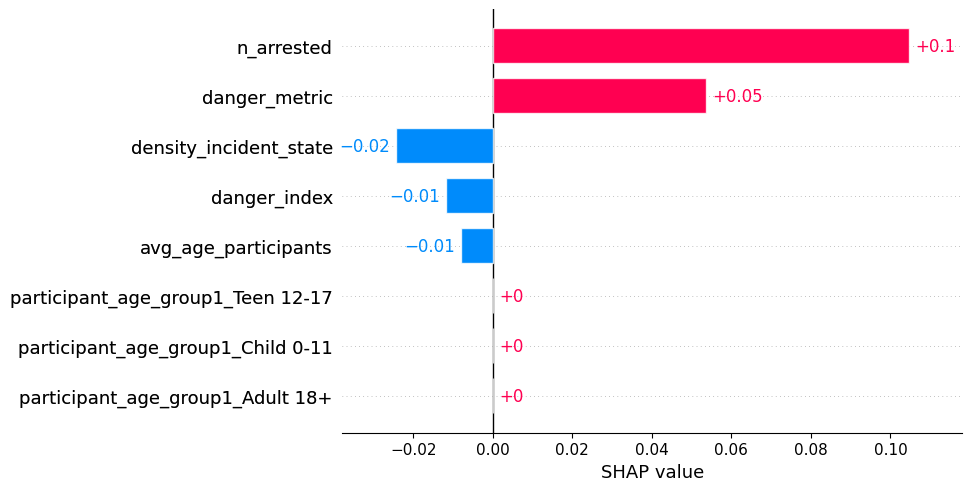

In [27]:
shap_value_bar_1 = explainer_entropy(test_set.iloc[0])
shap.plots.bar(shap_value_bar_1[:,0], max_display=10, show=True)


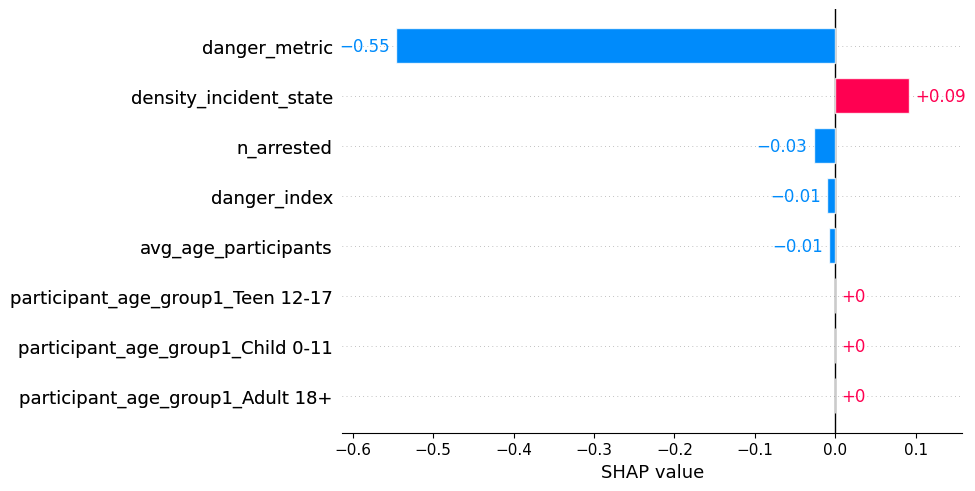

In [28]:
shap_value_bar_2 = explainer_entropy(test_set.iloc[105])
shap.plots.bar(shap_value_bar_2[:,0], max_display=10, show=True)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


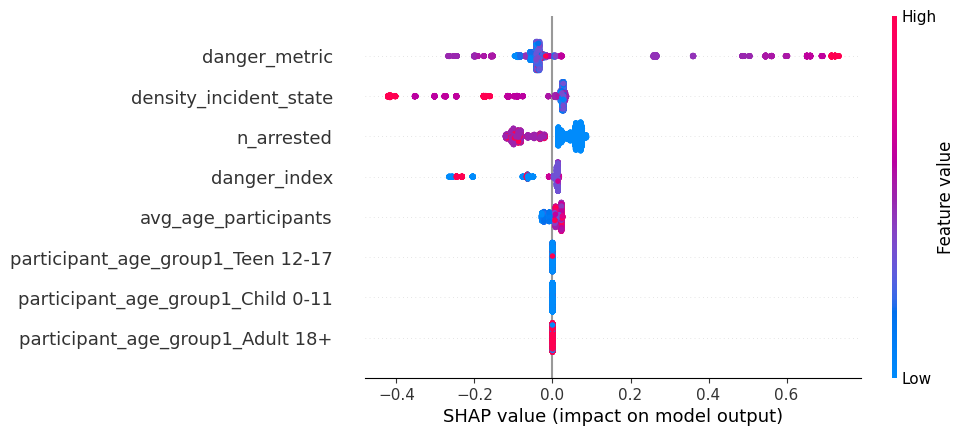

In [29]:
shap.plots.beeswarm(shap_value_bar_general[:,:,1])


In [30]:
shap.initjs()

In [31]:
shap.plots.force(shap_value_bar_general[:100,:,0])


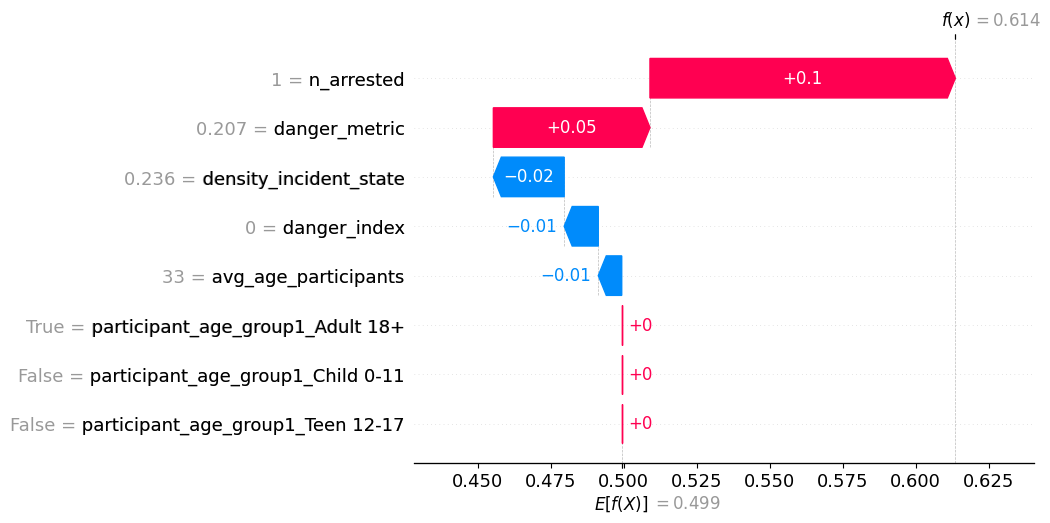

In [32]:
shap.plots.waterfall(shap_value_bar_general[0,:,0]) #False prediction on istance 0


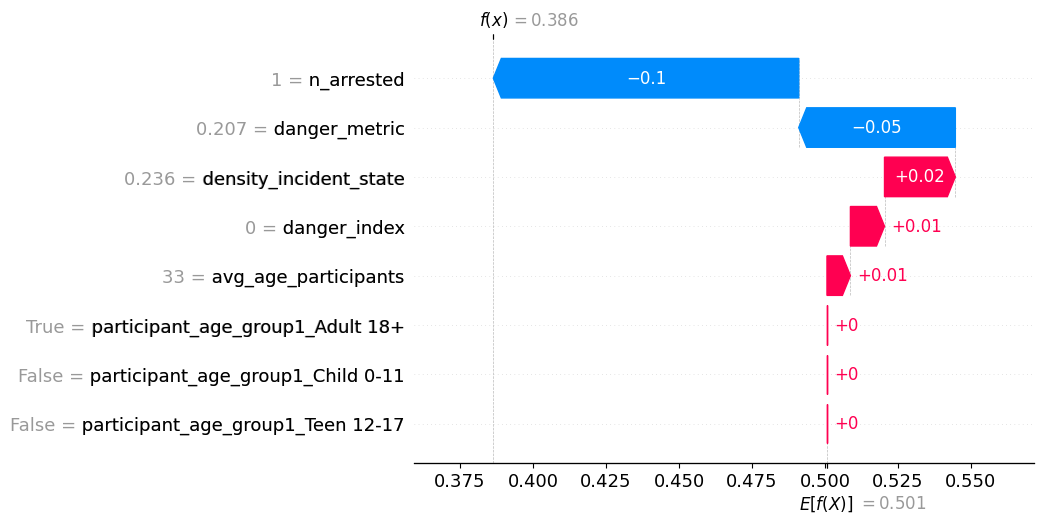

In [33]:
shap.plots.waterfall(shap_value_bar_general[0,:,1]) #True predicition on instance 0


## EBM

In [34]:
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

#create ebm model and fit
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(train_set, train_label)

ExplainableBoostingClassifier()

In [35]:
#Understand the model globally
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140410196876240/ -->

In [36]:
# Understand individual predictions
ebm_local = ebm.explain_local(train_set, train_label)
show(ebm_local)

<!-- http://127.0.0.1:7001/140410196959552/ -->

In [37]:
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# train Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(train_set, train_label)

# get predictions
rf_train_predictions = random_forest_model.predict_proba(train_set)[:, 1]
rf_test_predictions = random_forest_model.predict_proba(test_set)[:, 1]

# add predictions as new cols
train_set_with_rf_predictions = train_set.copy()
train_set_with_rf_predictions['rf_predictions'] = rf_train_predictions

test_set_with_rf_predictions = test_set.copy()
test_set_with_rf_predictions['rf_predictions'] = rf_test_predictions

# cteate an EBM model and train it with the predictions of random forest 
ebm_rf = ExplainableBoostingClassifier(random_state=42)
ebm_rf.fit(train_set_with_rf_predictions, train_label) #train_label

# Visualizza la distribuzione delle classi nel dataset
hist = ClassHistogram().explain_data(train_set_with_rf_predictions, train_label)
# Visualizza il modello EBM
ebm_global_rf = ebm.explain_global(name='EBM_RF')
show([hist, ebm_global])

<!-- http://127.0.0.1:7001/140414784843264/ -->
 Open in new window

In [38]:

from sklearn.tree import DecisionTreeClassifier

# new dt
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(train_set, train_label)

# get results on train and test set
dt_train_predictions = decision_tree_model.predict_proba(train_set)[:, 1]
dt_test_predictions = decision_tree_model.predict_proba(test_set)[:, 1]

# add the previosions of dt as new columns
train_set_with_dt_predictions = train_set.copy()
train_set_with_dt_predictions['dt_predictions'] = dt_train_predictions

test_set_with_dt_predictions = test_set.copy()
test_set_with_dt_predictions['dt_predictions'] = dt_test_predictions

# Crate and train the model
ebm_dt = ExplainableBoostingClassifier(random_state=42)
ebm_dt.fit(train_set_with_dt_predictions, train_label)

hist_dt = ClassHistogram().explain_data(train_set_with_dt_predictions, train_label)

# Visualizza il modello EBM per il Decision Tree
ebm_global_dt = ebm_dt.explain_global(name='EBM_DT')
show([hist_dt, ebm_global_dt])

<!-- http://127.0.0.1:7001/140414783788160/ -->
 Open in new window

In [39]:
# Confronta le interpretazioni globali di Random Forest e Decision Tree
show([hist, ebm_global_rf, ebm_global_dt])

<!-- http://127.0.0.1:7001/140414784755136/ -->
 Open in new window